[View in Colaboratory](https://colab.research.google.com/github/mari-linhares/tensorflow-brasil/blob/eager-hub/tfhub_classificador_caes_e_gatos.ipynb)

## Transfer learning com TFhub para um classificador de imagens


[Jupyter notebook no Github]()

[TensorFlow Hub](https://www.tensorflow.org/hub/) é uma biblioteca armazenamento e compartilhamento de modelos (ou parte de modelos) implementados com TensorFlow.

Essa biblioteca permite facilmente:
1. Reusar parte de modelos já treinados (Transfer learning)
2. Retreinar modelos (Fine tunning)
3. Compartilhar resultados

Nesse tutorial vamos focar em como usar TensorFlow hub para fazer [Transfer learning](http://cs231n.github.io/transfer-learning/) que consiste em utilizar camadas iniciais de um modelo já treinadas e reaproveitar esse conhecimento (sem retreinar essas camadas!). Para aprender algo sobre nosso próprio problema adicionamos novas camadas e essas sim nós treinamos nos nossos dados.  Se essa explicação não ajudou o diagrama abaixo talvez ajude :).

![Transfer learning](https://indico.io/blog/wp-content/uploads/2016/02/transfer_learning_nathan.jpg)

## Dependências

In [1]:
!pip install tensorflow --upgrade tensorflow==1.7.0
!pip install tensorflow-hub
!pip install matplotlib

Double requirement given: tensorflow==1.7.0 (already in tensorflow, name='tensorflow')


#### Importando dependências

In [1]:
# Compatibilidade entre Python 2 e Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
try:
  import urllib.request as urrlib_request # Python 3
except:
  import urllib as urllib_request  # Python 2
import tarfile
import zipfile


# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
tf.logging.set_verbosity(tf.logging.INFO)  # Permitindo visualização de logs

# Bibliotecas auxiliares
try:
  import cPickle  # maior eficiência ao processar as imagens
except:
  import _pickle as cPickle

import numpy as np  # manipular vetores
from PIL import Image  # lidar com imagens
import matplotlib.pyplot as plt  # plotar imagens
%matplotlib inline

import glob  # lidar com arquivos

tf.logging.info('Recomenda-se para esta atividade uma versão >= 1.7.0')
tf.logging.info('Sua versão do TensorFlow {}'.format(tf.__version__))
tf.logging.info('GPU disponível? {}'.format('Sim' if tf.test.is_gpu_available() else 'Não'))

%matplotlib inline

INFO:tensorflow:Recomenda-se para esta atividade uma versão >= 1.7.0
INFO:tensorflow:Sua versão do TensorFlow 1.7.0
INFO:tensorflow:GPU disponível? Sim


## Buscando e tratando os dados

Pode ignorar essa parte do código caso seu foco seja apenas aprender mais sobre TensorFlow especificamente. Aqui o que é feito é:
* Os dados são baixados caso necessário.
* As imagens são tratadas: shapes corrigidas, valores normalizados...


### Baixando os dados

O código abaixo foi basicamente copiado diretamente de: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/download.py pois esse não é o foco desse tutorial.

In [0]:
def _print_download_progress(count, block_size, total_size):
  """
  Function used for printing the download progress.
  Used as a call-back function in maybe_download_and_extract().
  """

  # Percentage completion.
  pct_complete = float(count * block_size) / total_size

  # Status-message. Note the \r which means the line should overwrite itself.
  msg = "\r- Download progress: {0:.1%}".format(pct_complete)

  # Print it.
  sys.stdout.write(msg)
  sys.stdout.flush()


def maybe_download_and_extract(url="https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
                               download_dir="."):
  """
  Download and extract the data if it doesn't already exist.
  Assumes the url is a tar-ball file.
  :param url:
      Internet URL for the tar-file to download.
      Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
  :param download_dir:
      Directory where the downloaded file is saved.
      Example: "data/CIFAR-10/"
  :return:
      Nothing.
  """

  # Filename for saving the file downloaded from the internet.
  # Use the filename from the URL and add it to the download_dir.
  filename = url.split('/')[-1]
  file_path = os.path.join(download_dir, filename)

  # Check if the file already exists.
  # If it exists then we assume it has also been extracted,
  # otherwise we need to download and extract it now.
  if not os.path.exists(file_path):
      # Check if the download directory exists, otherwise create it.
      if not os.path.exists(download_dir):
          os.makedirs(download_dir)

      # Download the file from the internet.
      file_path, _ = urllib_request.urlretrieve(url=url,
                                                filename=file_path,
                                                reporthook=_print_download_progress)

      print()
      print("Download finished. Extracting files.")

      if file_path.endswith(".zip"):
          # Unpack the zip-file.
          zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
      elif file_path.endswith((".tar.gz", ".tgz")):
          # Unpack the tar-ball.
          tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

      print("Done.")
  else:
      print("Data has apparently already been downloaded and unpacked.")

In [4]:
maybe_download_and_extract(url='http://files.fast.ai/data/dogscats.zip')

Data has apparently already been downloaded and unpacked.


In [5]:
!ls  # checando se a nova pasta foi criada
!ls 'dogscats/'  # checando o que tem dentro dela
DATA_DIR = 'dogscats/'  # "apontando" para nova pasta

datalab  dogscats  dogscats.zip
models	sample	test1  train  valid


#### Visualizando algumas imagens do dataset e seus labels

In [6]:
# Temos cada imagem individualmente
gatos = glob.glob(os.path.join(DATA_DIR, 'train', 'cats', '*'))[:5]
gatos

['dogscats/train/cats/cat.5107.jpg',
 'dogscats/train/cats/cat.6903.jpg',
 'dogscats/train/cats/cat.808.jpg',
 'dogscats/train/cats/cat.8896.jpg',
 'dogscats/train/cats/cat.9613.jpg']

Exemplo de 6 imagens da base de treino
11500 11500


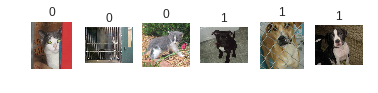

In [7]:
def visualizar_dados_treino(num_imgs_por_classe, data_dir):
    '''Essa função apresenta alguns dados de treino (imagens, labels) escolhidos aleatoriamente.
       Parâmetros:
           num_imgs_por_classe (int): número de imagens apresentadas por classe.
           data_dir (string): onde os arquivos foram baixados.
    '''

    print('Exemplo de %d imagens da base de treino' % (num_imgs_por_classe * 2))
    
    # Obtemos as imagens
    treino_path = os.path.join(data_dir, 'train')
    gatos = os.listdir(os.path.join(treino_path, 'cats'))
    caes = os.listdir(os.path.join(treino_path, 'dogs'))
    
    # Escolhemos índices aleatórios
    print(len(gatos), len(caes))
    random_ind_gato = np.random.choice(len(gatos), num_imgs_por_classe, replace=False)
    random_ind_cao = np.random.choice(len(caes), num_imgs_por_classe, replace=False)
    
    # Buscando imagens e labels
    imagens = [gatos[r] for r in random_ind_gato] + [caes[r] for r in random_ind_cao]
    labels = [0] * num_imgs_por_classe + [1] * num_imgs_por_classe
    
    # Plottando imagens
    for index, (img, label) in enumerate(zip(imagens, labels)):
        if 'cat' in img:
          path = os.path.join(treino_path, 'cats')
        else:
          path = os.path.join(treino_path, 'dogs')
        
        img = plt.imread(os.path.join(path, img))
        
        plt.subplot(4, num_imgs_por_classe * 2, index + 1)
        plt.axis('off')
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.title('%i' % label)
    plt.show()

visualizar_dados_treino(3, DATA_DIR)

### Usando Tf.data para lidar com os dados!

Tf.data é uma api fléxivel e rápida que permite manipular desde uma pequena quantidade de dados até dados que não cabem na memória. 

In [0]:
def _img_string_to_tensor(image_string, image_size=(299, 299)):
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Convert from full range of uint8 to range [0,1] of float32.
    image_decoded_as_float = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    # Resize to expected
    image_resized = tf.image.resize_images(image_decoded_as_float, size=image_size)
    
    return image_resized

def get_dataset(file_pattern, image_size=(224, 224), shuffle=False,
                batch_size=64, num_epochs=None, buffer_size=4096):
    def _path_to_img(path):
        # Get the parent folder of this file to get it's class name
        label = tf.string_split([path], delimiter='/').values[-2]
        # Read in the image from disk
        image_string = tf.read_file(path)
        image_resized = _img_string_to_tensor(image_string, image_size)
        
        return image_resized, label

    dataset = tf.data.Dataset.list_files(file_pattern).repeat(num_epochs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size)
 
    dataset = dataset.map(_path_to_img)
    dataset = dataset.batch(batch_size).prefetch(buffer_size)

    return dataset

### Importando modelo com TensorFlow Hub

Basicamente o que você precisa pra importar um modelo é uma URL. As URLs oficiais do TensorFlow tem o seguinte formato:

![](https://lh3.googleusercontent.com/j37Bi4iiDtIemo_a2tQ1gIxYVRzTi8qsHxZkAOl-eaGGhBldDICP3lvwC2elQ6h2cchuM3TQ698Mpg=w1920-h948-rw)


In [7]:
BATCH_SIZE = 32
nasnet = hub.Module("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1")
height, width = hub.get_expected_image_size(nasnet)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'.
INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_1/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block1/unit_1/bottleneck_v2/conv1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_1/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block1/unit_1/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9

INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_2/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block1/unit_2/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_2/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block1/unit_2/bottleneck_v2/conv2/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_2/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block1/unit_2/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block1/unit_2/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e

INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_1/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d

INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_2/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_2/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_2/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_2/bottleneck_v2/conv3/biases
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_2/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_2/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_2/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_2/

INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_4/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_4/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_4/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_4/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_4/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_4/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_4/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e61059

INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_5/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_5/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_5/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_5/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_5/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_5/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_6/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variab

INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_7/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_7/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_7/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_7/bottleneck_v2/conv2/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_7/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block2/unit_7/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block2/unit_7/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_1/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_10/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_10/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_10/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_10/bottleneck_v2/conv3/biases
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_10/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_10/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_10/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_12/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_12/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_12/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_12/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_12/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_12/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_12/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_13/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_13/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_13/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_13/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_13/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_13/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_14/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_15/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_15/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_15/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_15/bottleneck_v2/conv2/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_15/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_15/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_15/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_17/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_18/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_18/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_18/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_18/bottleneck_v2/preact/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_18/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_18/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_18/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/bloc

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_2/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d2419

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_20/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_20/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_21/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_21/bottleneck_v2/conv1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_21/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_21/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_21/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e58

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_22/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_22/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_22/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_22/bottleneck_v2/conv3/biases
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_22/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_22/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_22/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_24/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_24/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_24/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_24/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_24/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_24/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_24/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_25/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_25/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_25/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_25/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_25/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_25/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_26/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_27/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_27/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_27/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_27/bottleneck_v2/conv2/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_27/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_27/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_27/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_29/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_3/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_3/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_3/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_3/bottleneck_v2/preact/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_3/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_3/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_3/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_31/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d06330

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_32/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_32/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_33/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_33/bottleneck_v2/conv1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_33/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_33/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_33/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e58

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_34/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_34/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_34/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_34/bottleneck_v2/conv3/biases
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_34/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_34/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_34/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_36/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_36/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_36/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_36/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_36/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_36/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_36/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_4/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_4/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_4/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_4/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_4/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_4/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_5/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variab

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_6/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_6/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_6/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_6/bottleneck_v2/conv2/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_6/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_6/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_6/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_8/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d

INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_9/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_9/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_9/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_9/bottleneck_v2/preact/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_9/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit_9/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block3/unit_9/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block3/unit

INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_2/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block4/unit_2/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_2/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block4/unit_2/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_2/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block4/unit_2/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_2/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e61059

INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_3/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block4/unit_3/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_3/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block4/unit_3/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_152/block4/unit_3/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/block4/unit_3/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_152/conv1/biases:0 from checkpoint /tmp/tfhub_modules/8d0633058d241900a3e5895be9e610592a5e1fac/variables/variables with resnet_v2_152/conv1/biases


In [12]:
print("Height:", height, "Width:", width)

Height: 299 Width: 299


In [0]:
train_files = os.path.join(DATA_DIR, 'train', '**/*9.jpg')
test_files = os.path.join(DATA_DIR, 'valid', '**/*.jpg')

In [0]:
num_epochs = 1
train_ds = get_dataset(train_files, batch_size=BATCH_SIZE, shuffle=True, image_size=(height, width), num_epochs=num_epochs)
test_ds = get_dataset(test_files, batch_size=BATCH_SIZE, image_size=(height, width), num_epochs=1, shuffle=False)

In [0]:
# create a iterator of the correct shape and type
iter = tf.data.Iterator.from_structure(train_ds.output_types, train_ds.output_shapes)
x, y = iter.get_next()


# create the initialisation operations
train_init_op = iter.make_initializer(train_ds)
test_init_op = iter.make_initializer(test_ds)

In [0]:
logits = nasnet(x)

In [0]:
dense = tf.layers.dense(logits, 64, activation=tf.tanh)
y_ = tf.layers.dense(dense, 2)

mapping_string = tf.constant(["cats", "dogs"])
table = tf.contrib.lookup.index_table_from_tensor(
    mapping=mapping_string, num_oov_buckets=1, default_value=-1)

ids = table.lookup(y)
loss = tf.losses.sparse_softmax_cross_entropy(labels=ids, logits=y_)
train_op = tf.train.AdamOptimizer().minimize(loss)

prediction = tf.argmax(y_, axis=1, output_type=tf.int32)
accuracy, accuracy_op = tf.metrics.accuracy(labels=ids, predictions=prediction)

In [0]:
with tf.Session() as sess:
    sess.run(train_init_op) # switch to train dataset
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    sess.run(tf.tables_initializer())
    
    while True:
      try:
        _, loss_value = sess.run([train_op, loss])
        print(sess.run(accuracy_op), loss_value)
      except:
        break
    
    sess.run(test_init_op) # switch to val dataset
    while True:
      try:
        print(sess.run([accuracy_op, prediction, ids]))
      except:
        break

0.9375 0.47709927
0.9375 0.16609213
0.9479167 0.14691544
0.9609375 0.14278047
0.9625 0.04407204
0.9635417 0.072999604
0.96428573 0.11890416
